# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

np.random.seed(1)


## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability 
*   delayed healing 
*   partial paresis 
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\]. 

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2022-09-20 22:50:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: ‘diabetes_data_upload.csv.2’

diabetes_data_uploa 100%[===================>]  33.87K  --.-KB/s    in 0.07s   

2022-09-20 22:50:31 (497 KB/s) - ‘diabetes_data_upload.csv.2’ saved [34682/34682]



In [ ]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [ ]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [ ]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')



In [ ]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20. 
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [ ]:
#This class describes a fully connected layer (without activation function)

class Linear:
    # W: weight matrix (in x out)
    # b: bias (out x 1)
    
    #Constructor - we define the parameters of this layer
    def __init__(self, num_inputs, num_outputs, learning_rate, name):
      #The parameters are initialized randomly - uniform distribution (0,1)
      self.W = np.random.rand(num_inputs, num_outputs)
      self.b = np.zeros((num_outputs, 1))
      self.lr = learning_rate
      self.name = name
    
    # input: mini-batch (batch_size x in)
    # This function only operates the linear function
    def forward(self, input):
      self.inputs = input
      return np.dot(self.inputs, self.W) + self.b.T
    
    # dy: Error in next layer (batch_size x out)
    # This functions receives the error of the next layer and computes the error in this layer
    def backward(self, dy):
      batch_size = dy.shape[0]
      dy = dy.T # (out x batch_size)
      dw = dy.dot(self.inputs) #(out x in)
      db = np.sum(dy, axis=1, keepdims=True) #(out x 1)
      dx = np.dot(dy.T, self.W.T) # (batch_size x out) x (out x in)
       
      #SGD Rules
      self.W -= (self.lr/batch_size)*dw.T
      self.b -= (self.lr/batch_size)*db
        
      #The function computes the error in this layer and returns it for backpropagation
      return dx

#Class for the ReLU activation function
class ReLU:
  def __init__(self):    
    pass
  
  def forward(self, input):
    self.input = input
    ret = input.copy()
    ret[ret<0] = 0
    return ret
  
  def backward(self, dy):
    dx = dy.copy()
    dx[self.input<0] = 0
    return dx

#Class for the sigmoid activation function
class Sigmoid:
    def __init__(self):
      pass
    
    #Computes the sigmoid function
    def forward(self, inputs):
      self.output = 1/(1 + np.exp(-inputs))
      return self.output
    
    #Backpropagates the incoming error using the derivative of sigmoid
    def backward(self, dy):
      return dy*self.output*(1-self.output) # dy/4



In [ ]:
#Loss function
def mse(output, labels):
  return 0.5*np.sum((output-labels)**2)

#Class for the neural network
class NetworkReLU:
    def __init__(self,lr):  # Se recibe el learning rate para que el cambio de este sea más rápido
        
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons
      self.layers = [] 
      self.layers.append(Linear(num_inputs=16, num_outputs=5, learning_rate=lr, name='fc1'))
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=lr, name='fc3')) 
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)
    
    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label,verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
        
      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0
      
        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one 
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]

        #Random mini-batch
        
                                
          acc = 0
                
          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output          
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout
                    
        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)
                                  
        #Test after one epoch
        loss = 0
        outputs = []
            
        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]
                                
          acc = 0
                
          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output
                
          loss += mse(output, label)
                
          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()
            
        loss /= test_data.shape[0]
        test_loss.append(loss)
            
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
                    
      return dict({'train_loss': train_loss, 'test_loss':test_loss})
    
    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]
            
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
            
        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()
        
      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
                    
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
                    
        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)
      
      return np.vstack(output_pred)

In [ ]:
start_time = time.time()
net = NetworkReLU(lr=0.01)
history = net.train(X_train, Y_train, 20, 1000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.14216282642460532: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.1332082325078851: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.11855834016564396: Test accuracy=73.07692307692308
Epoch 60/1000: loss = 0.08349414960697171: Test accuracy=74.03846153846153
Epoch 80/1000: loss = 0.07916074219670413: Test accuracy=80.76923076923077
Epoch 100/1000: loss = 0.07537680647064607: Test accuracy=80.76923076923077
Epoch 120/1000: loss = 0.07170589108455395: Test accuracy=84.61538461538461
Epoch 140/1000: loss = 0.0680286507290082: Test accuracy=88.46153846153847
Epoch 160/1000: loss = 0.06432126459881987: Test accuracy=88.46153846153847
Epoch 180/1000: loss = 0.06068338640971863: Test accuracy=86.53846153846153
Epoch 200/1000: loss = 0.05725506147761768: Test accuracy=86.53846153846153
Epoch 220/1000: loss = 0.05415113680304361: Test accuracy=87.5
Epoch 240/1000: loss = 0.051424337231068436: Test accuracy=91.34615384615384
Epoch 260/1000: loss = 0.0490721

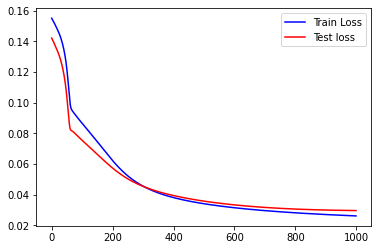

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [ ]:
start_time = time.time()

net = NetworkReLU(lr=0.01)
history = net.train(X_train, Y_train, 1, 1000, X_test, Y_test) # Mini batch de tamaño 1

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.15656963134108556: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.051821665363289623: Test accuracy=86.53846153846153
Epoch 40/1000: loss = 0.03168253542271843: Test accuracy=92.3076923076923
Epoch 60/1000: loss = 0.029691350591529754: Test accuracy=91.34615384615384
Epoch 80/1000: loss = 0.03063390843793634: Test accuracy=91.34615384615384
Epoch 100/1000: loss = 0.03173923730286699: Test accuracy=91.34615384615384
Epoch 120/1000: loss = 0.032692929067019746: Test accuracy=91.34615384615384
Epoch 140/1000: loss = 0.03353603732990176: Test accuracy=91.34615384615384
Epoch 160/1000: loss = 0.0343026212335305: Test accuracy=91.34615384615384
Epoch 180/1000: loss = 0.03500347095132414: Test accuracy=92.3076923076923
Epoch 200/1000: loss = 0.03564334568539631: Test accuracy=92.3076923076923
Epoch 220/1000: loss = 0.036220200355544144: Test accuracy=92.3076923076923
Epoch 240/1000: loss = 0.036709760458457884: Test accuracy=92.3076923076923
Epoch 260/1000: los

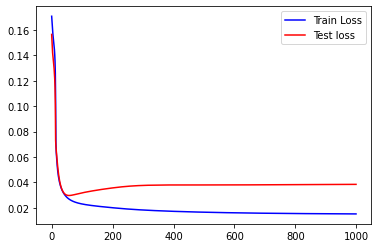

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

In [ ]:
start_time = time.time()

net = NetworkReLU(lr=0.01)
history = net.train(X_train, Y_train, 416, 1000, X_test, Y_test) # Minibatch de tamaño igual al total de detos

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.15257522814361948: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.1522194436335132: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.15186161561295813: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.15150176075500654: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.15113989516157783: Test accuracy=61.53846153846154
Epoch 100/1000: loss = 0.1507760342708021: Test accuracy=61.53846153846154
Epoch 120/1000: loss = 0.15041019276104445: Test accuracy=61.53846153846154
Epoch 140/1000: loss = 0.15004238445156587: Test accuracy=61.53846153846154
Epoch 160/1000: loss = 0.14967262219977048: Test accuracy=61.53846153846154
Epoch 180/1000: loss = 0.14930091779497792: Test accuracy=61.53846153846154
Epoch 200/1000: loss = 0.14892728184864992: Test accuracy=61.53846153846154
Epoch 220/1000: loss = 0.14855172368098574: Test accuracy=61.53846153846154
Epoch 240/1000: loss = 0.14817425120378844: Test accuracy=61.53846153846154
Epoch 260/1000: loss

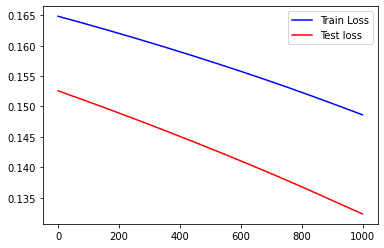

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

## Comentarios parte 2
El accuracy en el primer caso (tamaño del minibatch igual a 1) es notablemente mejor, esto debido a que usar un minibatch de tamaño 1, es equivalente a utilizar el método de gradiente sin realizar las aproximaciones del método  estocástico. Por lo que hay una mayor exactitud. Es posible notar además que la red del primer caso posee un mejor rendimiento, tanto en el entrenamiento como en los test.

Es posible notar que, la ganancia de exactitud es a costa del tiempo de computo, es decir, hacer pasar los datos de uno en uno por la red (minibatch de tamaño 1) toma un mayor tiempo (44 segundos versus 0.32 segundos) que hacer pasar los 416 en una sola pasada realizando una aproximanción que tiene como resultado un aumento en el error (menos exacta).

La opción más óptima solo cambiando el tamaño del batch a un número constante, estaría en un punto medio (como el caso de la parte 1), en la cual el tiempo de computo es relativamente bajo pero la pérdida en el accuracy sigue siendo aceptable.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.


##Learning rate de lr=0.5

In [ ]:
net = NetworkReLU(lr=0.5)
history = net.train(X_train, Y_train, 20, 1000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/1000: loss = 0.14648410032239698: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.030339941056367923: Test accuracy=91.34615384615384
Epoch 40/1000: loss = 0.03395628758131318: Test accuracy=89.42307692307692
Epoch 60/1000: loss = 0.03616962555316207: Test accuracy=91.34615384615384
Epoch 80/1000: loss = 0.03756160687011622: Test accuracy=92.3076923076923
Epoch 100/1000: loss = 0.038356212318939376: Test accuracy=92.3076923076923
Epoch 120/1000: loss = 0.03868217624295451: Test accuracy=92.3076923076923
Epoch 140/1000: loss = 0.03874876587944998: Test accuracy=92.3076923076923
Epoch 160/1000: loss = 0.03871044201615406: Test accuracy=92.3076923076923
Epoch 180/1000: loss = 0.03864727643936367: Test accuracy=92.3076923076923
Epoch 200/1000: loss = 0.03860126612651084: Test accuracy=92.3076923076923
Epoch 220/1000: loss = 0.03858387866849852: Test accuracy=92.3076923076923
Epoch 240/1000: loss = 0.038593362849713195: Test accuracy=92.3076923076923
Epoch 260/1000: loss = 0

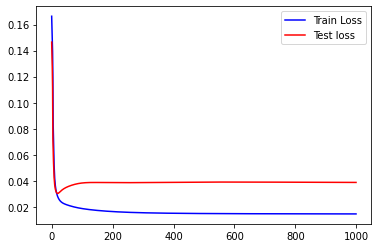

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

##Learning rate de lr=0.000001

In [ ]:
net = NetworkReLU(lr=0.00001)
history = net.train(X_train, Y_train, 20, 1000, X_test, Y_test)
print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/1000: loss = 0.14601863332731585: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.14601271762259: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.1460068017271316: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.14600088564092698: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.14599496936396214: Test accuracy=61.53846153846154
Epoch 100/1000: loss = 0.14598905289622296: Test accuracy=61.53846153846154
Epoch 120/1000: loss = 0.14598313623769513: Test accuracy=61.53846153846154
Epoch 140/1000: loss = 0.1459772193883638: Test accuracy=61.53846153846154
Epoch 160/1000: loss = 0.14597130234821426: Test accuracy=61.53846153846154
Epoch 180/1000: loss = 0.1459653851172314: Test accuracy=61.53846153846154
Epoch 200/1000: loss = 0.14595946769539975: Test accuracy=61.53846153846154
Epoch 220/1000: loss = 0.14595355008270383: Test accuracy=61.53846153846154
Epoch 240/1000: loss = 0.14594763227912771: Test accuracy=61.53846153846154
Epoch 260/1000: loss = 0

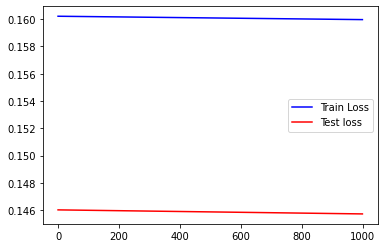

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

In [ ]:
net = NetworkReLU(lr=100)
history = net.train(X_train, Y_train, 20, 1000, X_test, Y_test)
print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/1000: loss = 0.1923074825030147: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.19230743898717786: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.19230737334282555: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.19230726323989447: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.19230704156369216: Test accuracy=61.53846153846154
Epoch 100/1000: loss = 0.1923063745833865: Test accuracy=61.53846153846154
Epoch 120/1000: loss = 0.1922627347597969: Test accuracy=61.53846153846154
Epoch 140/1000: loss = 0.3076922883083964: Test accuracy=38.46153846153846
Epoch 160/1000: loss = 0.30769227545106953: Test accuracy=38.46153846153846
Epoch 180/1000: loss = 0.30769225339586004: Test accuracy=38.46153846153846
Epoch 200/1000: loss = 0.3076922063516294: Test accuracy=38.46153846153846
Epoch 220/1000: loss = 0.3076920345453891: Test accuracy=38.46153846153846
Epoch 240/1000: loss = 0.19230769230769232: Test accuracy=61.53846153846154
Epoch 260/1000: loss = 0

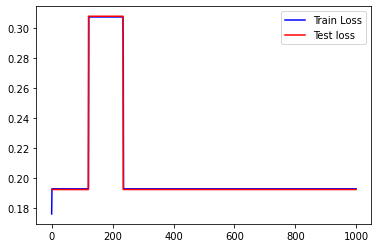

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

##Comentarios parte 3
Es posible notar que el learning rate determinta la velocidad con que el algoritmo 'converge'. Es decir, un learning rate pequeño hará con los pasos para acercarse al mínimo serán lentos y por tanto serán necesarios más épocas (vemos en el caso de un lr=0.000001 que las pérdidas son pequeñas y que el accuracy mejora muy lento), mientras que un learning rate alto hará que se alcance el mínimo más rápido. Sin embargo, si el learning es demasiado alto, se corre el riesgo de que el algoritmo no pueda encontrar nunca el mínimo y salte al rededor de este.

Se puede ver que en el primer caso (lr=0.5) el mínimo se alcanza, en cambio en el caso de un learning rate de 100, el algoritmo no alcanza el mínimo.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [ ]:
#Class for the neural network
class NetworkReLU_rand:
    def __init__(self,lr):
        
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons
      self.layers = [] 
      self.layers.append(Linear(num_inputs=16, num_outputs=5, learning_rate=lr, name='fc1'))
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=lr, name='fc3')) 
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)
    
    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, epoch, test_data, test_label,verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
        
      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0

        # Tamaño del minibatch
        batch_size=np.random.randint(1,training_data.shape[0]+1)
      
        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one 
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]
    
          acc = 0
                
          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output          
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout
                    
        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)
                                  
        #Test after one epoch
        loss = 0
        outputs = []
            
        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]
                                
          acc = 0
                
          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output
                
          loss += mse(output, label)
                
          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()
            
        loss /= test_data.shape[0]
        test_loss.append(loss)
            
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}: Minibatch size = {}'.format(e, epoch, loss, (100*correct)/test_label.shape[0], batch_size))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}: Minibatch size = {}'.format(e, epoch, loss, (100*correct)/test_label.shape[0], batch_size))
                    
      return dict({'train_loss': train_loss, 'test_loss':test_loss})
    
    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]
            
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
            
        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()
        
      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
                    
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
                    
        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)
      
      return np.vstack(output_pred)

In [ ]:
start_time = time.time()
net = NetworkReLU_rand(lr=0.01)
history = net.train(X_train, Y_train, 1000, X_test, Y_test)
print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.15362783746152847: Test accuracy=61.53846153846154: Minibatch size = 34
Epoch 20/1000: loss = 0.14680432568391297: Test accuracy=61.53846153846154: Minibatch size = 159
Epoch 40/1000: loss = 0.14575713991455158: Test accuracy=61.53846153846154: Minibatch size = 277
Epoch 60/1000: loss = 0.14449174048976637: Test accuracy=61.53846153846154: Minibatch size = 124
Epoch 80/1000: loss = 0.14272672724659186: Test accuracy=61.53846153846154: Minibatch size = 259
Epoch 100/1000: loss = 0.1414253745837222: Test accuracy=64.42307692307692: Minibatch size = 360
Epoch 120/1000: loss = 0.13917542460086968: Test accuracy=69.23076923076923: Minibatch size = 72
Epoch 140/1000: loss = 0.1377977777421297: Test accuracy=71.15384615384616: Minibatch size = 141
Epoch 160/1000: loss = 0.1362810997861596: Test accuracy=73.07692307692308: Minibatch size = 143
Epoch 180/1000: loss = 0.1348261340981143: Test accuracy=73.07692307692308: Minibatch size = 152
Epoch 200/1000: loss = 0.1331878

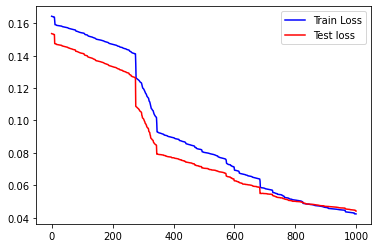

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

##Comentarios parte 4

Al comparar con el gráfico de la parte 1, es posible notar que se necesitan un número mayor de epocas para alcanzar el mínimo. Además es posible notar que el grafico de la parte 4 da 'saltos', lo cual se puede asociar al cambio del tamaño de los batch en cada iteración.

Si bien el algoritmo converge más lento en término de las epocas, es posible notar que en este caso toma un menor tiempo de computo (al rededor de 1 segundo), lo cual, el comparar con los casos de la parte 2 en los cuales se usaba un tamaño constante. entrega la mejor opción en el trade off tiempo de computo/accuracy (pues el accuracy es casi del 90%). Esto se debe a que una inicialización aleatoria de los batch incluye rapidez (caundo el batch es grande) y a la vez exactitud (cuando el batch es pequeño).


